In [1]:
import os
import random
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import numpy as np
from tqdm import tqdm
import random
from skimage.draw import bezier_curve
from scipy.ndimage import gaussian_filter
import json
from torch.utils.data import Dataset, DataLoader
import torch
import time

In [2]:
random.seed(42)
np.random.seed(42)
data_dir = './COCO_dset_adaptation/reduced_dset'

In [3]:
# === Paths ===
ann_file = os.path.join(data_dir, 'annotations', 'instances_train2014.json')
img_dir = os.path.join(data_dir, 'train2014')

# === Load COCO ===
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
# === Dataset preprocessing ===
input_dir = os.path.join(data_dir, 'masks')
output_dir = os.path.join(data_dir, 'coarse_masks')

os.makedirs(output_dir, exist_ok=True)

mask_files = [f for f in os.listdir(input_dir) if f.endswith('.npy')]

def random_coarse(mask):
    # Convert to uint8 and ensure contiguous
    mask = np.ascontiguousarray((mask * 255).astype(np.uint8))

    # Step 1: Generate a band around the edge
    contour_band = cv2.dilate(mask, np.ones((7, 7), np.uint8), iterations=1)
    contour_band = cv2.subtract(contour_band, mask)

    # Get coordinates where noise can be placed (in edge band)
    edge_coords = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, dtype=np.uint8)

    # Add random circles only around the contour area
    num_circles = random.randint(15, 40)
    for _ in range(num_circles):
        if len(edge_coords) == 0:
            break
        y, x = edge_coords[random.randint(0, len(edge_coords) - 1)]
        radius = random.randint(3, 10)
        cv2.circle(noise, (x, y), radius, 255, -1)

    # Combine noise with original mask
    mask = cv2.bitwise_or(mask, noise)

    # Step 2: Random dilation
    dilate_kernel_size = random.randint(7, 15)
    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_kernel_size, dilate_kernel_size))
    mask = cv2.dilate(mask, kernel_dilate, iterations=random.randint(1, 2))

    # Step 3: Random erosion
    erode_kernel_size = random.randint(5, dilate_kernel_size - 1)
    kernel_erode = cv2.getStructuringElement(random.choice([
        cv2.MORPH_ELLIPSE, cv2.MORPH_RECT, cv2.MORPH_CROSS
    ]), (erode_kernel_size, erode_kernel_size))
    mask = cv2.erode(mask, kernel_erode, iterations=1)

    # Step 4: Gaussian blur + threshold for soft borders
    blur = cv2.GaussianBlur(mask, (5, 5), sigmaX=random.uniform(2.0, 4.5))
    _, coarse_mask = cv2.threshold(blur, random.randint(60, 120), 1, cv2.THRESH_BINARY)

    return coarse_mask.astype(np.uint8)


def random_coarse_v2(mask):
    mask = np.ascontiguousarray((mask > 0).astype(np.uint8) * 255)

    band_width   = random.randint(15, 40)                      
    contour_band = cv2.dilate(mask,
                              cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                                        (band_width, band_width)),
                              iterations=1)
    contour_band = cv2.subtract(contour_band, mask)
    edge_coords  = np.column_stack(np.where(contour_band > 0))

    noise = np.zeros_like(mask, np.uint8)
    num_circles = random.randint(8, 18)                        
    for _ in range(num_circles):
        y, x = edge_coords[random.randrange(len(edge_coords))]
        radius = random.randint(band_width//2, band_width)     
        cv2.circle(noise, (x, y), radius, 255, -1)

    mask = cv2.bitwise_or(mask, noise)

    close_size = random.randint(band_width//2, band_width)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (close_size, close_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

    blur = cv2.GaussianBlur(mask, (0, 0), sigmaX=random.uniform(6.0, 12.0)) 
    _, coarse = cv2.threshold(blur, 127, 1, cv2.THRESH_BINARY)

    return coarse.astype(np.uint8)


def random_coarse_distanza(mask, sigma_noise=12, blur_sigma=6.0, bias=12):

    mask = (mask > 0).astype(np.uint8)

    d_in  = cv2.distanceTransform(mask,  cv2.DIST_L2, 3)
    d_out = cv2.distanceTransform(1-mask, cv2.DIST_L2, 3)
    signed = d_in - d_out                 

    noise = np.random.randn(*mask.shape).astype(np.float32)
    noise = cv2.GaussianBlur(noise, (0,0), blur_sigma)

    d_hat = signed + sigma_noise * noise - bias
    coarse = (d_hat > 0).astype(np.uint8)

    return coarse



print(f"Generating coarse masks for {len(mask_files)} masks...")

for fname in tqdm(mask_files):
    mask_path = os.path.join(input_dir, fname)
    mask = np.load(mask_path)  # shape: (H, W)

    coarse_mask = random_coarse_v2(mask)
    
    # Save new mask
    coarse_name = fname.replace('splitmask', 'coarsemask')
    output_path = os.path.join(output_dir, coarse_name)
    np.save(output_path, coarse_mask)

Generating coarse masks for 178 masks...


100%|██████████| 178/178 [00:03<00:00, 52.51it/s]


In [5]:
# === Visualize original and coarse masks ===
class CoarseMaskDataset(Dataset):
    def __init__(self, mask_dir, transform_type="v2"):
        self.mask_paths = [os.path.join(mask_dir, f)
                           for f in os.listdir(mask_dir) if f.endswith('.npy')]
        self.transform_type = transform_type

    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        mask = np.load(self.mask_paths[idx])  # shape: (H, W)

        if self.transform_type == "v1":
            coarse = random_coarse(mask)
        elif self.transform_type == "v2":
            coarse = random_coarse_v2(mask)
        elif self.transform_type == "dist":
            coarse = random_coarse_distanza(mask)
        else:
            raise ValueError("Unknown transform type")

        # Convert to torch tensors with shape (1, H, W)
        mask_tensor = torch.tensor((mask > 0).astype(np.uint8), dtype=torch.float32).unsqueeze(0)
        coarse_tensor = torch.tensor(coarse, dtype=torch.float32).unsqueeze(0)

        return coarse_tensor, mask_tensor


In [6]:
# === Function to mantain original dimension ===
def collate_fn_variable(batch):
    coarse_list, mask_list = zip(*batch)
    return list(coarse_list), list(mask_list)


In [7]:
dataset = CoarseMaskDataset(mask_dir=input_dir, transform_type="v2")
loader = DataLoader(dataset, batch_size=15, shuffle=True, collate_fn=collate_fn_variable)

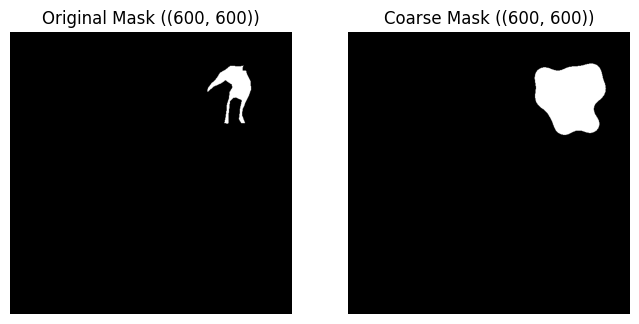

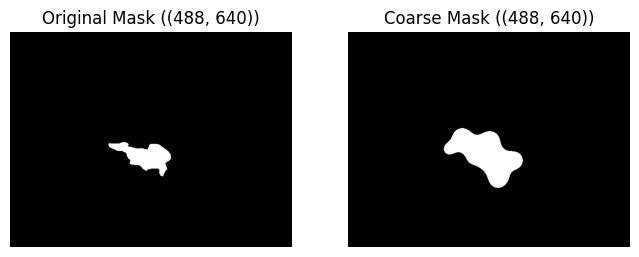

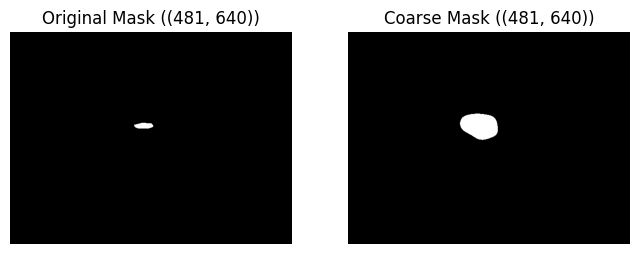

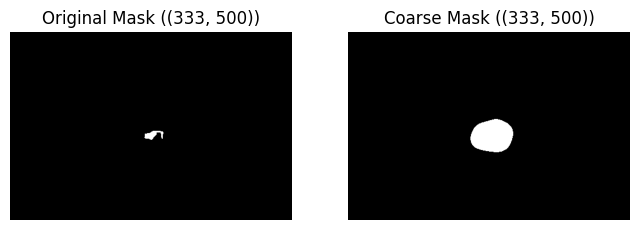

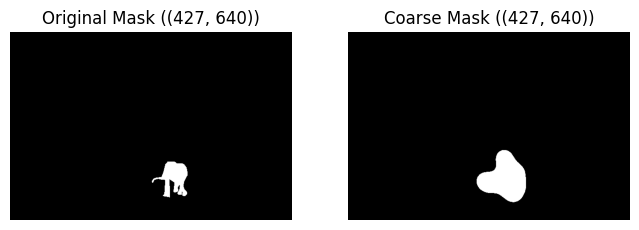

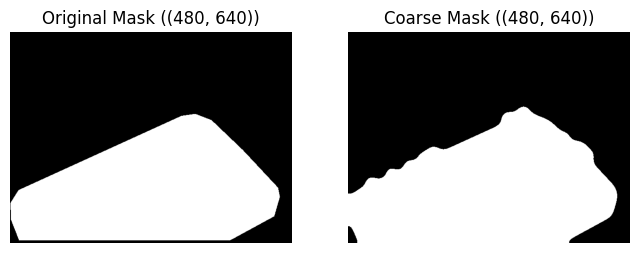

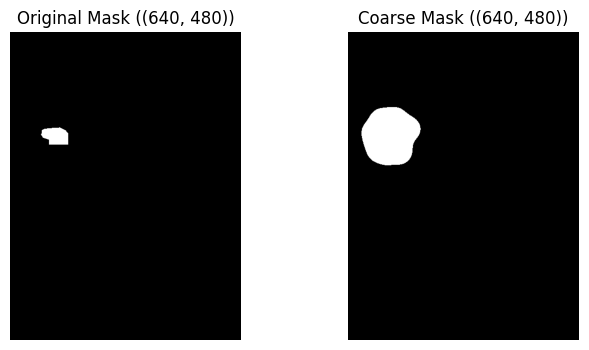

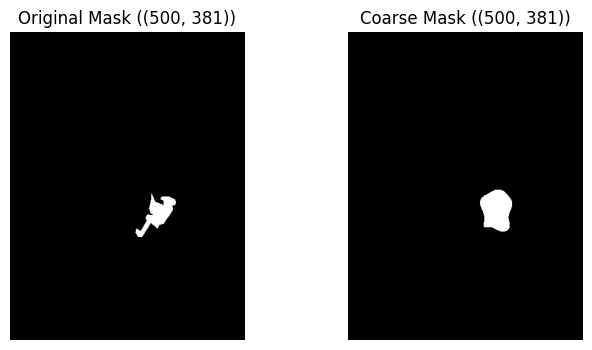

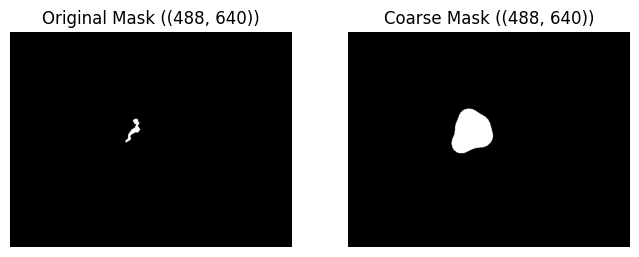

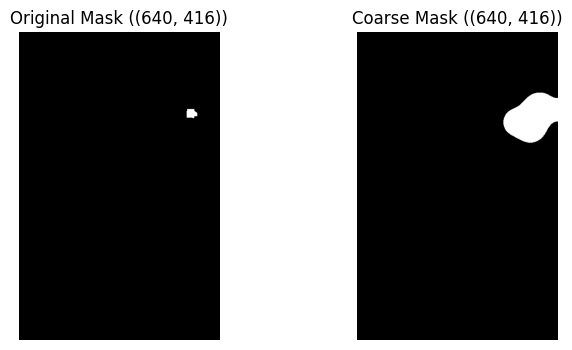

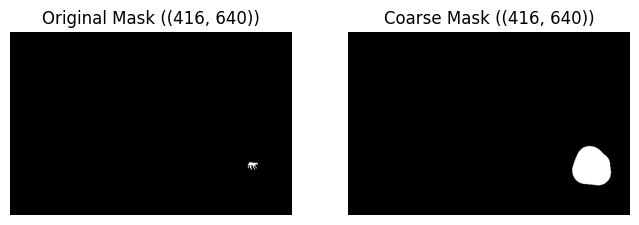

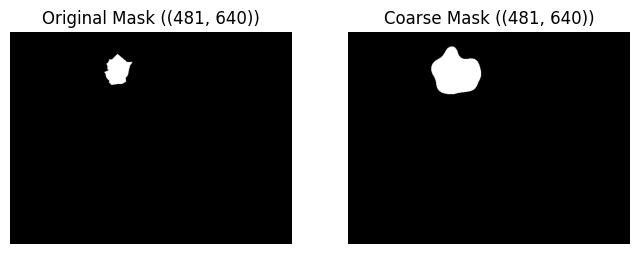

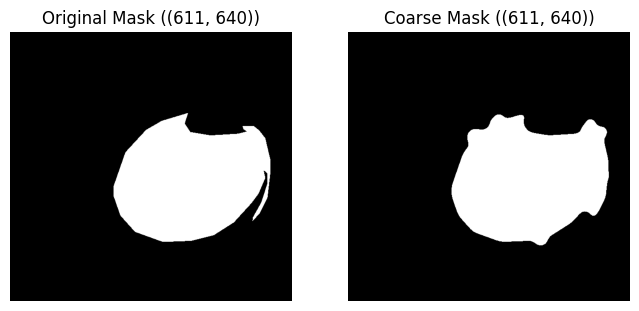

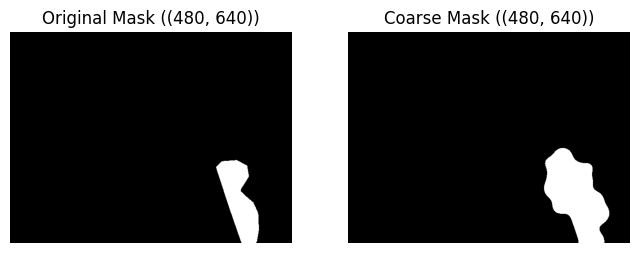

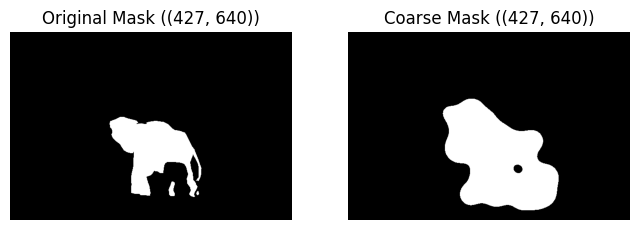

In [8]:

coarse_batch, original_batch = next(iter(loader))

for i in range(len(coarse_batch)):
    coarse = coarse_batch[i][0].numpy()
    original = original_batch[i][0].numpy()

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title(f'Original Mask ({original.shape})')
    axs[1].imshow(coarse, cmap='gray')
    axs[1].set_title(f'Coarse Mask ({coarse.shape})')
    for ax in axs: ax.axis('off')
    plt.show()

In [9]:
len(dataset)

178

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, 2, 2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        skip = []
        for down in self.downs:
            x = down(x)
            skip.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip = skip[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            if x.shape != skip[i//2].shape:
                x = F.interpolate(x, size=skip[i//2].shape[2:])
            x = torch.cat([skip[i//2], x], dim=1)
            x = self.ups[i+1](x)

        return self.final_conv(x)

class Coarse2FineUNet(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.model = UNet(in_channels=1, out_channels=1)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x_list, y_list = batch
        losses = []
        for x, y in zip(x_list, y_list):
            x = x.unsqueeze(0).to(self.device)
            y = y.unsqueeze(0).to(self.device)
            logits = self(x)
            loss = self.loss_fn(logits, y)
            losses.append(loss)
        total_loss = torch.stack(losses).mean()
        self.log("train_loss", total_loss)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [11]:
from pytorch_lightning import Trainer

model = Coarse2FineUNet()
trainer = Trainer(max_epochs=10, accelerator="gpu" if torch.cuda.is_available() else "cpu", log_every_n_steps=1)
trainer.fit(model, loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\ACER\OneDrive\Desktop\NeuralTrasferello\ailab\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 31.0 M | train
1 | loss_fn | BCEWit

Epoch 9: 100%|██████████| 12/12 [46:21<00:00,  0.00it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [46:23<00:00,  0.00it/s, v_num=5]


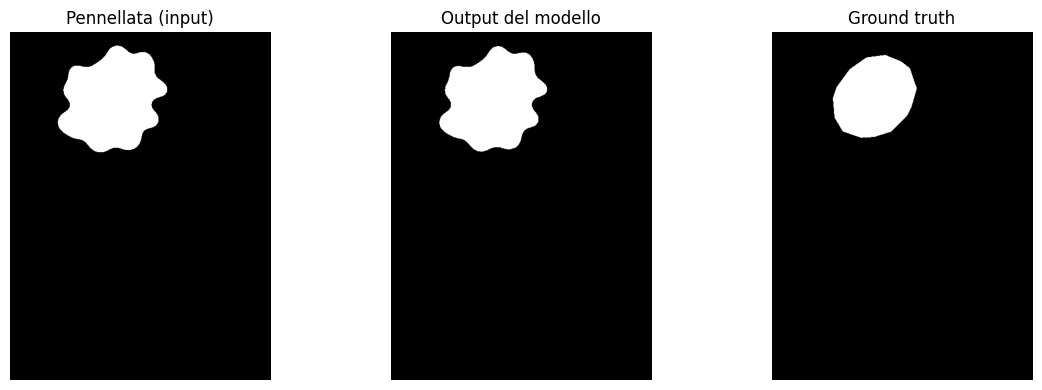

In [22]:
model.eval()

# Recupera un campione dal dataset
coarse, fine = dataset[25]  # puoi cambiare l'indice

# Sposta su GPU se disponibile
device = model.device
coarse = coarse.unsqueeze(0).to(device)  # shape (1, 1, H, W)

# Predizione
with torch.no_grad():
    pred_logits = model(coarse)
    pred_mask = torch.sigmoid(pred_logits).squeeze().cpu().numpy()  # shape (H, W)
    pred_binary = (pred_mask > 0.5).astype(float)

# Converti anche gli input per plotting
coarse_np = coarse.squeeze().cpu().numpy()
fine_np = fine.squeeze().cpu().numpy()

# --- Plot ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(coarse_np, cmap="gray")
plt.title("Pennellata (input)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_binary, cmap="gray")
plt.title("Output del modello")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(fine_np, cmap="gray")
plt.title("Ground truth")
plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

log_dir = sorted(glob.glob("lightning_logs/version_*"))[-1]
metrics_path = os.path.join(log_dir, "metrics.csv")

# Carica i log
df = pd.read_csv(metrics_path)

# Filtra solo righe valide per il training (evita righe vuote o con NaN)
df = df[df["train_loss"].notna()]

# Visualizza le prime righe per conferma
print(df.head(10))

   epoch  step  train_loss
0      0     0    0.712116
1      0     1    0.691295
2      0     2    0.661414
3      0     3    0.589679
4      0     4    0.553249
5      0     5    0.485796
6      0     6    0.570236
7      0     7    0.490529
8      0     8    0.493631
9      0     9    0.364038
